In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

In [2]:
all_hr_sig = np.load('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_hr_sig.npy', allow_pickle=True).item()

GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig = np.load('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig.npy', allow_pickle=True).item()
GM12878_ATAC_H3K27ac_2_100_all_enhanced_sig = np.load('temp/GM12878_ATAC_H3K27ac_2_100_all_enhanced_sig.npy', allow_pickle=True).item()
GM12878_ATAC_H3K4me3_2_100_all_enhanced_sig = np.load('temp/GM12878_ATAC_H3K4me3_2_100_all_enhanced_sig.npy', allow_pickle=True).item()

GM12878_ATAC_H3K27ac_H3K4me3_2_300_all_enhanced_sig = np.load('temp/GM12878_ATAC_H3K27ac_H3K4me3_2_300_all_enhanced_sig.npy', allow_pickle=True).item()
GM12878_ATAC_H3K27ac_2_300_all_enhanced_sig = np.load('temp/GM12878_ATAC_H3K27ac_2_300_all_enhanced_sig.npy', allow_pickle=True).item()
GM12878_ATAC_H3K4me3_2_300_all_enhanced_sig = np.load('temp/GM12878_ATAC_H3K4me3_2_300_all_enhanced_sig.npy', allow_pickle=True).item()

colors = [
    (0, 159/255, 232/255),
    (222/255, 28/255, 38/255),
    (0, 191/255, 82/255),
    (255/255, 122/255, 23/255)
]


In [3]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_results: dict, hr_result, colors_map, title):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (10, 10),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)
    
    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
    axes.grid(False)
    for key in mine_results.keys():
        axes.plot(x, mine_results[key], color=colors_map[key], label=key)
    axes.plot(x, hr_result, color=colors[3], label='High resolution')
    
    # 边框
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(2)
    axes.spines['left'].set_linewidth(2)
    axes.tick_params(axis='both', width=2, length=5)

    plt.xlabel('Distance ×1kb')
    plt.ylabel('NUM')
    plt.legend(loc='upper right', facecolor=(244/255, 244/255, 244/255)).get_frame().set_linewidth(0.0)
    plt.title(title)
    plt.savefig('figure_file/{}.pdf'.format(title))
    plt.show()

def figure(chip_seq_path, colors_map, title):
    all_enhanced_results = copy.deepcopy(colors_map)
    for key in all_enhanced_results.keys():
        all_enhanced_results[key] = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    _peaks = read_chiqseq_file(chip_seq_path)
    for chr in range(1, 23):
        if 'chr{}'.format(chr) not in _peaks.keys():
            continue
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])
        for key in all_enhanced_results.keys():
            enhanced_result = get_hit_indicators(all_enhanced_sig[key][chr], _peaks['chr{}'.format(chr)])
            all_enhanced_results[key] += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_results, all_hr_result, colors_map, title)

In [4]:
all_enhanced_sig = dict(
    H3K27ac_H3K4me3=GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig,
    H3K27ac=GM12878_ATAC_H3K27ac_2_100_all_enhanced_sig,
    H3K4me3=GM12878_ATAC_H3K4me3_2_100_all_enhanced_sig
)
auxiliary_files_path = '/data1/lmh_data/MINE/source/GM12878'

In [5]:
colors_map = dict(
    H3K27ac_H3K4me3=colors[0],
    H3K27ac=colors[1],
    H3K4me3=colors[2]
)

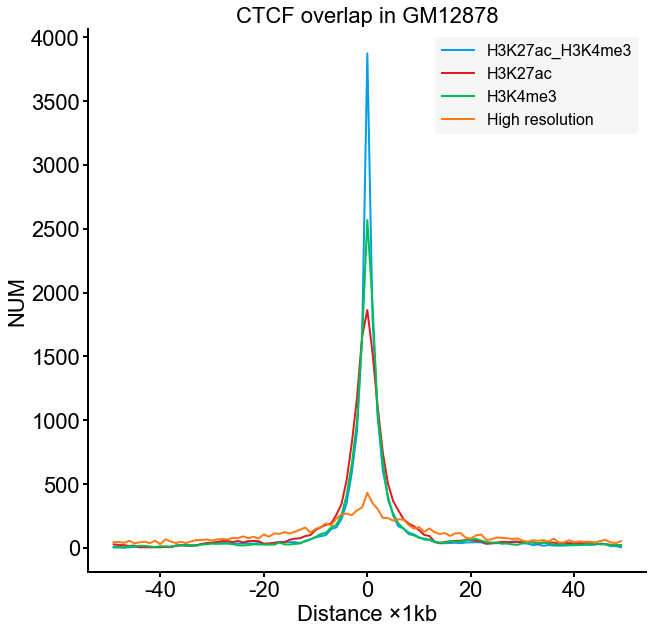

In [6]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path, colors_map, 'CTCF overlap in GM12878')

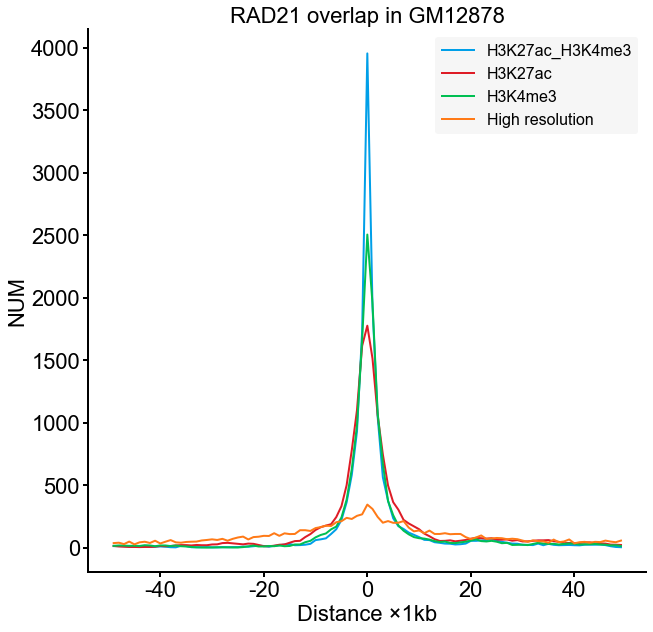

In [7]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path, colors_map, 'RAD21 overlap in GM12878')

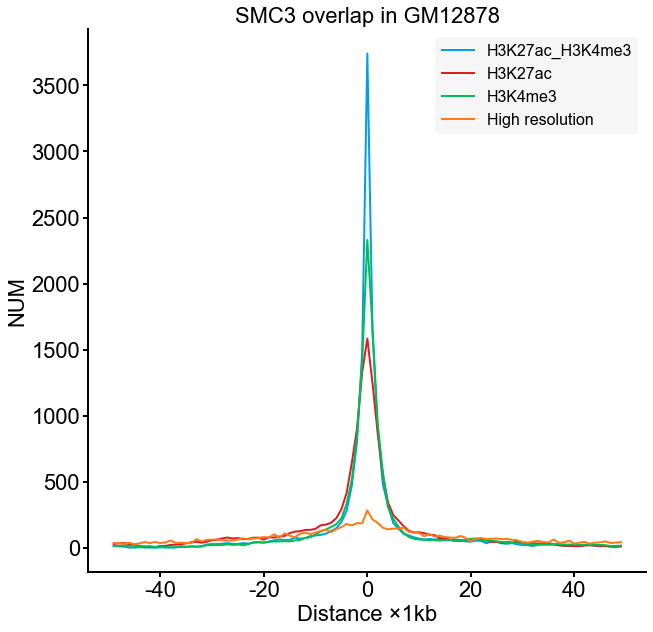

In [8]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path, colors_map, 'SMC3 overlap in GM12878')

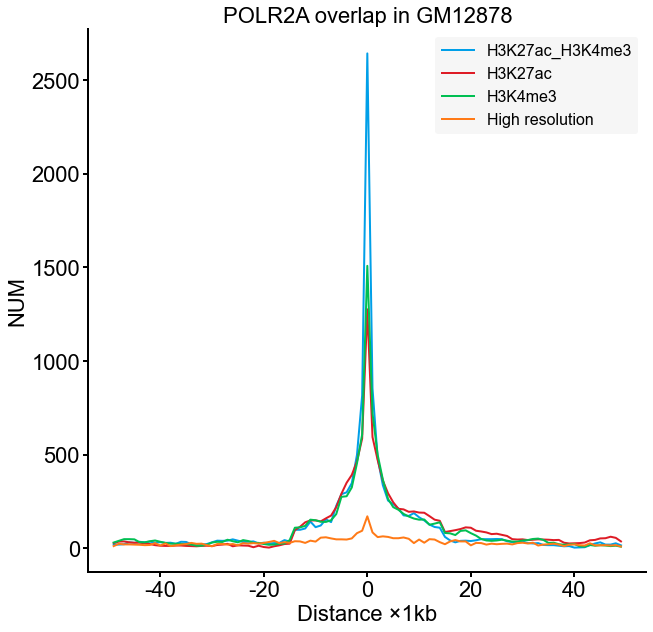

In [9]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path, colors_map, 'POLR2A overlap in GM12878')

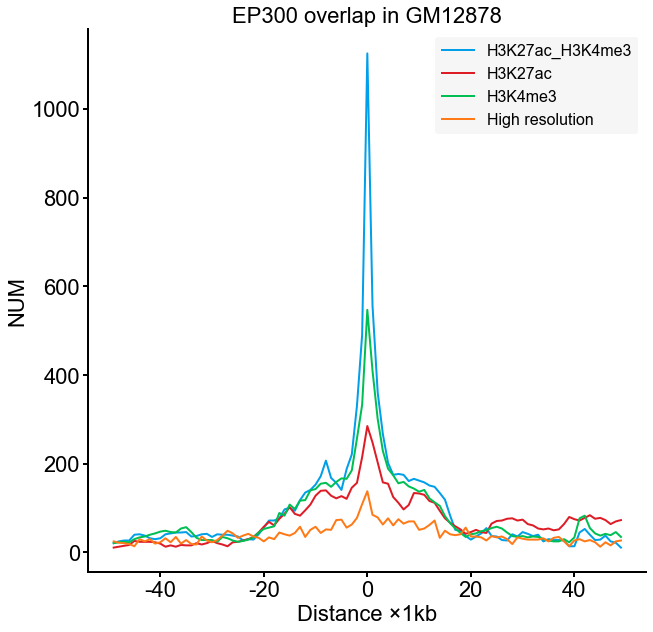

In [10]:
chip_seq_path = os.path.join(auxiliary_files_path, 'EP300_peaks.bed')
figure(chip_seq_path, colors_map, 'EP300 overlap in GM12878')

In [11]:
all_enhanced_sig = dict(
    H3K27ac_H3K4me3=GM12878_ATAC_H3K27ac_H3K4me3_2_300_all_enhanced_sig,
    H3K27ac=GM12878_ATAC_H3K27ac_2_300_all_enhanced_sig,
    H3K4me3=GM12878_ATAC_H3K4me3_2_300_all_enhanced_sig
)

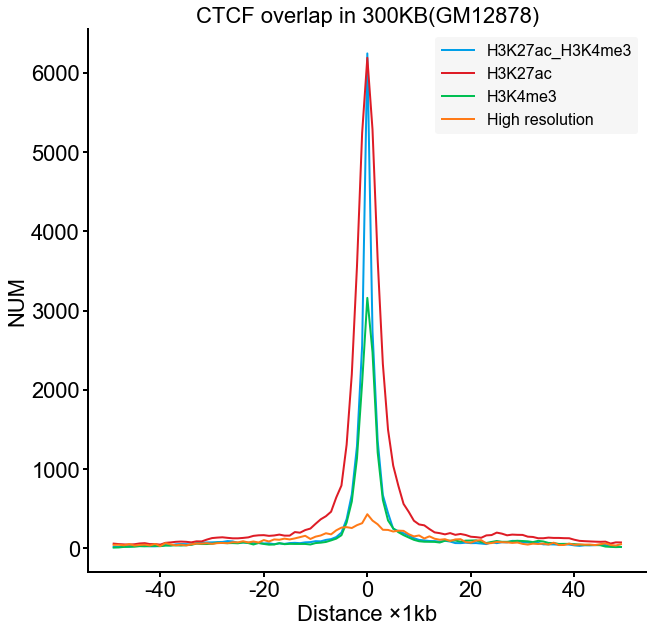

In [12]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path, colors_map, 'CTCF overlap in 300KB(GM12878)')

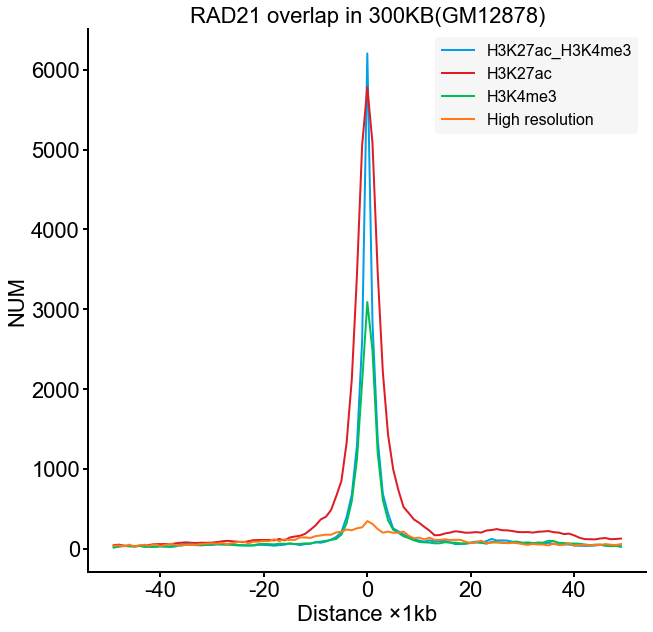

In [13]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path, colors_map, 'RAD21 overlap in 300KB(GM12878)')

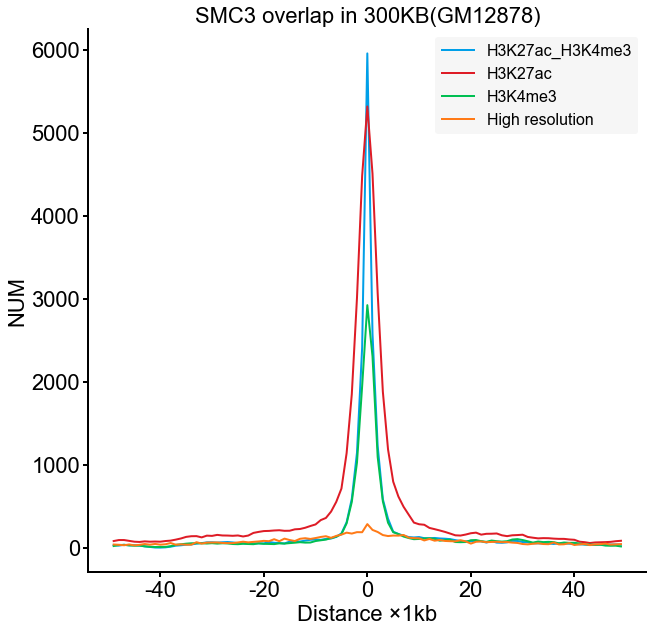

In [14]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path, colors_map, 'SMC3 overlap in 300KB(GM12878)')

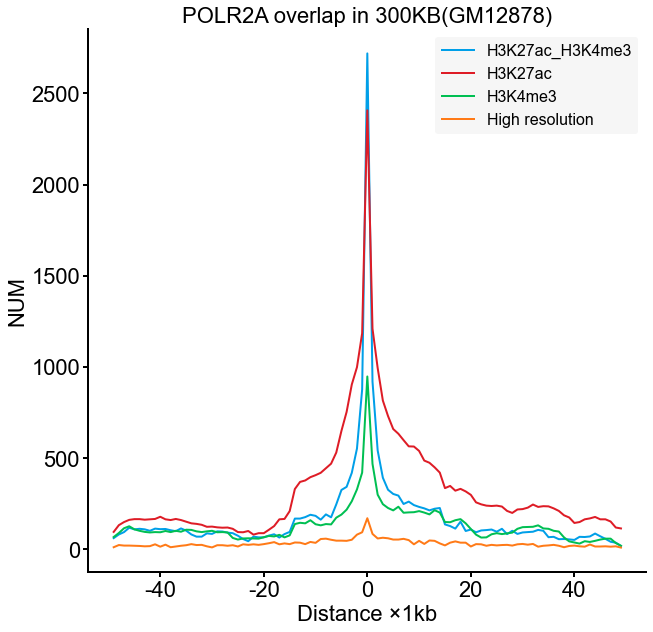

In [15]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path, colors_map, 'POLR2A overlap in 300KB(GM12878)')

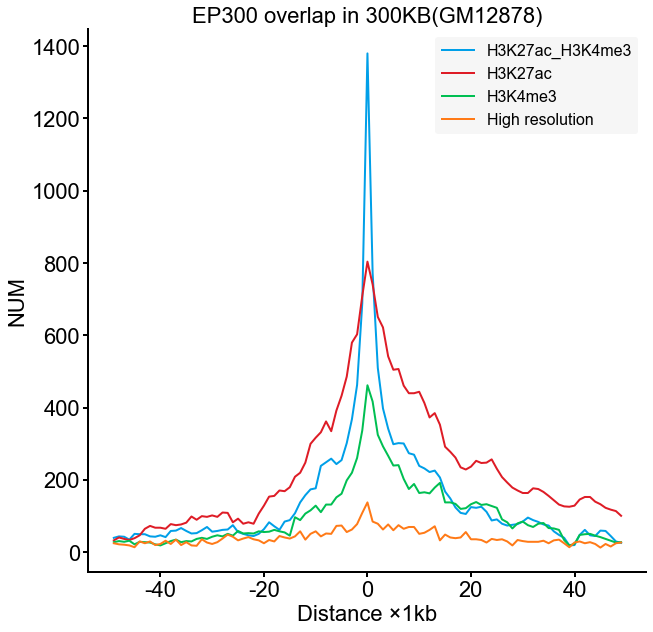

In [16]:
chip_seq_path = os.path.join(auxiliary_files_path, 'EP300_peaks.bed')
figure(chip_seq_path, colors_map, 'EP300 overlap in 300KB(GM12878)')

In [17]:
GM12878_H3K9me3_H3K27me3_2_100_all_enhanced_sig = np.load('represses/temp/GM12878_H3K9me3_H3K27me3_2_100_all_enhanced_sig.npy', allow_pickle=True).item()
all_enhanced_sig = dict(
    H3K27ac_H3K4me3=GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig,
    H3K9me3_H3K27me3=GM12878_H3K9me3_H3K27me3_2_100_all_enhanced_sig
)

colors_map = dict(
    H3K27ac_H3K4me3=colors[0],
    H3K9me3_H3K27me3=colors[1]
)

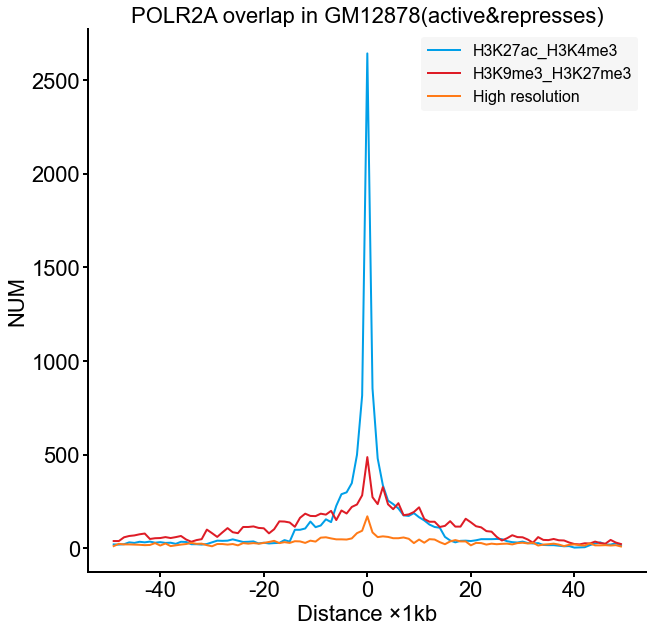

In [18]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path, colors_map, 'POLR2A overlap in GM12878(active&represses)')

In [19]:
colors_map = dict(
    H3K27ac_H3K4me3=colors[0],
    H3K9me3_H3K27me3=colors[1]
)

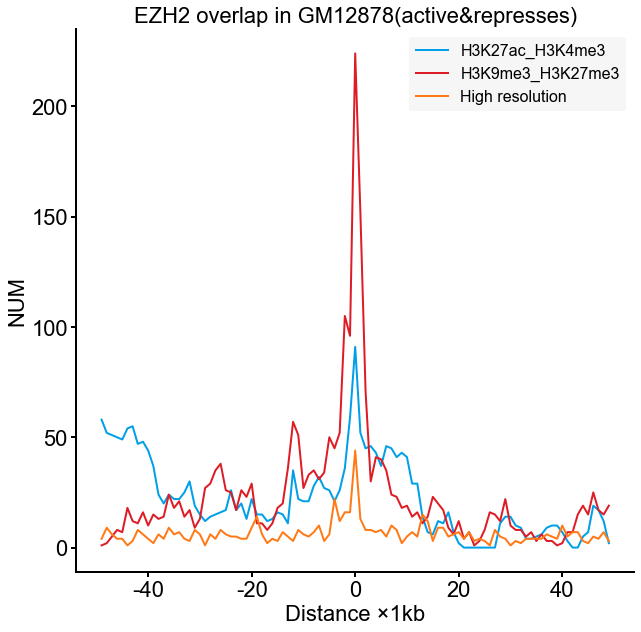

In [20]:
chip_seq_path = os.path.join(auxiliary_files_path, 'EZH2_peaks.bed')
figure(chip_seq_path, colors_map, 'EZH2 overlap in GM12878(active&represses)')